In [1]:
import tensorflow as tf
import loadData
import model
import numpy as np
import glob, sys
import matplotlib.pyplot as plt
import tqdm, os, cv2
%matplotlib inline

sys.path.append("/home/msmith/misc/py/")
sys.path.append("/home/msmith/misc/tfFunctions/")

from dice import dice
from performance import Performance
from hStackBatch import hStackBatch
from IPython.display import clear_output

def showBatch(x,y,yPred,unnormalize=1,name=""):
    x, y, yPred = [hStackBatch(im) for im in [x,y,yPred]]
    if unnormalize == 1:
        x *= 255
        y *= 255
        yPred *= 255

    x,y,yPred = [im.astype(np.uint8).squeeze()[:,:,::-1] for im in [x,y,yPred]]
    print("*"*100)
    plt.title(name)
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.imshow(x)
    plt.subplot(312)
    plt.imshow(np.vstack((y,yPred)))
    plt.show()

def mse(y,yPred):
	return tf.reduce_mean(tf.square(tf.sub(y,yPred)))

def trainer(loss,learningRate,momentum=0.9):
    return tf.train.AdamOptimizer(learningRate).minimize(loss)

def imgForSave(img,scale=255):
    return (img*scale).astype(np.uint8).squeeze()

Using TensorFlow backend.


In [2]:
if __name__ == "__main__":

        import matplotlib.pyplot as plt
        
        # What are we doing? Please choose one!
        trainTest = 0
        trainAll = 1
        fit = 0
        ss = 1 # semi supervised
        assert trainTest + trainAll + fit == 1, "Can only be doing one of these operations train/test, trainAll, fit"
        
        # File paths 
        toFitPaths = glob.glob("../../imgs/*/w1S*")[:201]
        trPaths = glob.glob("../augmented/train/x_*")
        tePathsAug = glob.glob("../augmented/testAugmented/x_*")
        tePaths = glob.glob("../augmented/test/x_*")
        
        
        # Hyperparams
        keepProbability = 1.0 # for dropout
        nFeatsInc = 32
        displayProb = 0.005
        learningRate = 0.001
        load = 1
        save = 1
        diceThreshold = 0.5
        nEpochs = 20
        batchSize = 4
        histMatch = 1
        
        matchingImg = "x_1"
        modelName = "model.tf"
        histMatchPath = ""
        ssPath = ""
        if histMatch == 1:
            print("Histogram matching")
            modelName = modelName.replace(".tf","HistMatch.tf")
            histMatchPath = "_histMatch"
        if ss == 1:
            print("Semi supervised")
            ssPath = "_ss"
        
        inDims = [batchSize,600,900,3]
        outDims = [batchSize,19,29,3]
       
        # Graph
        x, y, yPred = model.main(nFeatsInc=nFeatsInc)
        loss = mse(yPred,y)
        diceScore, _ = dice(yPred,y,diceThreshold)
        lr = tf.placeholder(tf.float32)
        train = trainer(loss,lr)

        saver = tf.train.Saver()
        
        folderName = "models/{0}_bS{1}_in{2}x{3}_out{4}x{5}_do{6}_featInc{7}{8}{9}/".format(matchingImg,
                                                                                      batchSize,
                                                                                      inDims[1],
                                                                                      inDims[2],
                                                                                      outDims[1],
                                                                                      outDims[2],
                                                                                      keepProbability,
                                                                                      nFeatsInc,
                                                                                      histMatchPath,
                                                                                      ssPath
                                                                                        )
        if os.path.exists(folderName) == 1:
            print("Model path @ {0} EXISTS".format(folderName))
        else:
            print("Model path @ {0} DOES NOT EXIST".format(folderName))
            os.mkdir(folderName)
        
        if trainAll == 1: # Change path and add test files to trainset
            folderName += "trainAll/"
            trPaths += tePathsAug 
            if not os.path.exists(folderName):
                os.mkdir(folderName)
        print("Path = {0}".format(folderName))

Histogram matching
Semi supervised
Model dims
('Layer 1 = ', [None, 600, 900, 3])
('Layer 2 = ', [None, 300, 450, 48])
('Layer 3 = ', [None, 150, 225, 80])
('Layer 4 = ', [None, 75, 113, 112])
('Layer 5 = ', [None, 38, 57, 144])
('Layer 6 = ', [None, 19, 29, 176])
('Layer 7 = ', [None, 19, 29, 3])
('Layer 8 = ', [None, 19, 29, 3])
Model path @ models/x_1_bS4_in600x900_out19x29_do1.0_featInc32_histMatch_ss/ EXISTS
Path = models/x_1_bS4_in600x900_out19x29_do1.0_featInc32_histMatch_ss/trainAll/


Loading
Doing semi-supervised prediction
Removed current predictions from '../augmented/semiSupervised/'
0 of 201


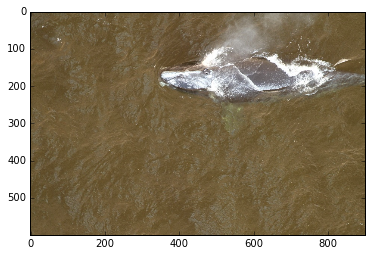

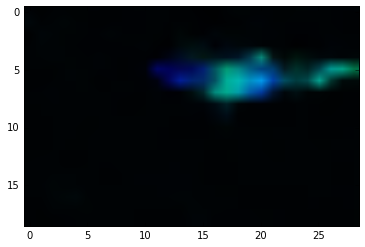

KeyboardInterrupt: 

In [3]:
if __name__ == "__main__":
        
        with tf.Session() as sess:

            if load == 1:
                if fit == 1:
                    folderName += "trainAll/" #Assume we are using all data99999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999++++6999+9-966666666666666666666666666666666666666666666666666662
                print("Loading")
                saver.restore(sess,folderName+modelName)
            else:
                init = tf.initialize_all_variables()
                sess.run(init)
            
            if fit == 0:
                
                # Peformance class
                trPerformance = Performance("train")
                tePerformance = Performance("test")
                
                # Main train loop
                for epoch in range(nEpochs)[:1]:
                    
                    if ss == 1:
                        print("Doing semi-supervised prediction")
                        for f in glob.glob("../augmented/semiSupervised/*"):
                            os.remove(f)
                        print("Removed current predictions from {0}".format("'../augmented/semiSupervised/'"))
                        inDimsSS, outDimsSS = list(inDims), list(outDims)
                        inDimsSS[0] = 1
                        outDimsSS[0] = 1
                        ssFeed = loadData.feed(inDims = inDimsSS, outDims = outDimsSS, paths = toFitPaths, matchingImg = matchingImg, histMatch = histMatch)
                        finSS = 0
                        count = 0
                        while finSS == 0:                        
                            X,Y,finSS,paths, originals = ssFeed.next()
                            original = imgForSave(originals,1)
                            yPred_ = yPred.eval(feed_dict = {x:X})
                            yPred_ = imgForSave(yPred_,255)
                            
                            wp = "../augmented/semiSupervised/y_{0}.jpg".format(count)
                            cv2.imwrite(wp,yPred_)
                            cv2.imwrite(wp.replace("y_","x_"),original)
                            if count % 200 == 0:
                                print("{0} of {1}".format(count,len(toFitPaths)))
                                plt.imshow(original[:,:,::-1])
                                plt.show()
                                plt.imshow(yPred_[:,:,::-1])
                                plt.show()
                            count += 1
                        
                        ssPaths = glob.glob("../augmented/semiSupervised/x_*")
                        trPaths += ssPaths
                        print("Added {0} semi-supervised paths to train on.".format(len(ssPaths)))
                        

                    if epoch > 2:
                        trPerformance.displayEpochPerformance()
                        tePerformance.displayEpochPerformance()  
                    
                    finTr = finTe = 0
                    print("EPOCH {0} of {1}".format(epoch,nEpochs))
                    print(learningRate)
                    trFeed = loadData.feed(inDims = inDims, outDims = outDims, paths = trPaths, matchingImg = matchingImg, histMatch = histMatch)
                    teFeed = loadData.feed(inDims = inDims, outDims = outDims, paths = tePaths, matchingImg = matchingImg, histMatch = histMatch)
                    
                    print("Training on {0} files.".format(len(trPaths)))
                    while finTr == 0:                        
                        X,Y,finTr,paths, _ = trFeed.next()
                        _, loss_, diceScore_, yPred_ = sess.run([train,loss,diceScore,yPred], feed_dict = {x:X,y:Y,lr:learningRate})
                        trPerformance.add(loss_,diceScore_)
                        if finTr == 1 or np.random.uniform() < displayProb:
                            showBatch(X,Y,yPred_,unnormalize=1 , name= "train")
                            trPerformance.displayCurrentPerformance()
                    trPerformance.endEpoch()
                    trPerformance.displayEpochPerformance()
                        
                    if trainAll != 1:
                        print("Testing on {0} files.".format(len(tePaths)))
                        while finTe == 0:
                            X,Y,finTe,paths, _ = teFeed.next()
                            loss_, diceScore_, yPred_ = sess.run([loss,diceScore,yPred], feed_dict = {x:X,y:Y})
                            tePerformance.add(loss_,diceScore_)
                            if finTe == 1 or np.random.uniform() < displayProb:
                                showBatch(X,Y,yPred_,unnormalize=1, name = "test")
                                tePerformance.displayCurrentPerformance()
                        tePerformance.endEpoch()
                        tePerformance.displayEpochPerformance()              
                    
                    if epoch > 0 and epoch % 2 == 0 :
                        learningRate/= 1.5
                        print("Dropped learning rate to {0:.6f}".format(learningRate))
                    if save == 1:
                        clear_output()

                        save_path = saver.save(sess, folderName+"/"+modelName)
                        trPerformance.writeToCsv(folderName+"trainPerf.csv")
                        if trainAll != 1:
                            tePerformance.writeToCsv(folderName+"testPerf.csv")
                        print("Saved in {0}".format(folderName))
                        
            elif fit == 1:
                 
                inDims[0], outDims[0] = 1,1 # One at a time 
                for paths in [toFitPaths[:]]:
                    print("*"*100)
                    paths = paths
                    fitFeed = loadData.feed(inDims = inDims, outDims = outDims, paths = paths, matchingImg = matchingImg, histMatch = histMatch)       
                    finFitting = 0
                    count = 0
                    while finFitting == 0:
                        X,_,finFitting,paths = fitFeed.next() 
                        yPred_ = sess.run([yPred], feed_dict = {x:X})
                        pred = yPred_[0].squeeze()*255
                        pred = pred.astype(np.uint8)
                        if np.random.uniform() < 0.01: 
                            plt.figure(figsize=(15,15))
                            plt.subplot(121); plt.imshow(X.squeeze()[:,:,::-1]) 
                            plt.subplot(122); plt.imshow(pred[:,:,::-1])
                            plt.title(paths[0])
                            plt.show()
                            count += 1
                            if count == 10:
                                clear_output()
                                count = 0
                        wp = paths[0].replace("w1S_","m1_")
                        cv2.imwrite(wp,pred)